Hemos comprobado cómo podemos interactuar con una LLM y cómo realizar acciones que vayan más allá de una sola pregunta. Si queremos explorar interacciones más complejas debemos introducirnos en el mundo de los agentes.

# Agentes

Un agente no es más que un intermediario entre el usuario y la LLM de forma que controlamos cómo se realizan las interacciones y además podemos presentar opciones adicionales como:

* El uso de **herramientas**
* Registro del **hilo de conversación**
* **Enriquecimiento** del contexto

Veamos algún ejemplo sencillo.

In [1]:
from dotenv import load_dotenv

load_dotenv(override=True)

True

Creamos una instancia de chat con instrucciones concretas.

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage

# LLM
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash", 
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

# System message
sys_msg = SystemMessage(content="Eres un asistente de matemáticas.")

Podemos dibujar el gráfico de interacción de manera sencilla.

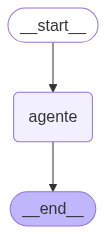

In [5]:
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from IPython.display import Image, display

# Asistente
def agente(state: MessagesState):
   return {"messages": [llm.invoke([sys_msg] + state["messages"])]}

# Grafo
builder = StateGraph(MessagesState)
builder.add_node("agente", agente)
builder.add_edge(START, "agente")
agente = builder.compile()

# Show
display(Image(agente.get_graph(xray=True).draw_mermaid_png()))

In [7]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content="¿Cuanto es 4 * 5?")]
messages = agente.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

¿Cuanto es 4 * 5?
================================== Ai Message ==================================

4 * 5 = 20


In [8]:
messages = [HumanMessage(content="¿Puedes multiplicar ese resultado por 2?")]
messages = agente.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

¿Puedes multiplicar ese resultado por 2?
================================== Ai Message ==================================

Claro que sí, puedo multiplicar cualquier número por 2.

Sin embargo, no tengo el contexto de un "resultado" anterior en esta conversación.

**¿Podrías decirme cuál es el número que quieres que multiplique por 2?** Una vez que me lo digas, con gusto haré el cálculo.


Como veis cada interacción es independiente. Esto nos viene bien con modelos convencionales ya que no queremos que la predicción anterior afecte a la actual, pero en una conversación es necesario que exista ese mecanismos de _recuerdo_. LangChain nos da la opción de establecer una memoria que se active en cada sesión, del mismo modo que ChatGPT puede seguir la conversación cuando interactuamos con este.

In [9]:
from langgraph.checkpoint.memory import MemorySaver

# Mecanismo de memoria
memory = MemorySaver()
agente_mem = builder.compile(checkpointer=memory)

# Hilo a seguir
config = {"configurable": {"thread_id": "1"}}

In [10]:
messages = [HumanMessage(content="¿Cuanto es 4 * 5?")]
messages = agente_mem.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

¿Cuanto es 4 * 5?
================================== Ai Message ==================================

4 * 5 = 20


In [12]:
messages = [HumanMessage(content="¿Puedes multiplicar ese resultado por 2?")]
messages = agente_mem.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

¿Cuanto es 4 * 5?
================================== Ai Message ==================================

4 * 5 = 20
================================ Human Message =================================

¿Puedes multiplicar ese resultado por 2?
================================== Ai Message ==================================

Claro.

El resultado anterior fue 20.
Si lo multiplicamos por 2:

20 * 2 = 40


Gracias a esto podemos desarrollar conversaciones elaboradas ya que el hilo de conversación es añadido a cada nuevo mensaje del usuario en lo que la ventana de contexto lo permita.

## Herramientas

Podemos hacer saber a la LLM que disponemos de herramientas (funciones) que podemos ejecutar de forma que en lugar de dejar que la LLM se imagine cómo sería una operación concreta, aportamos certidumbre ya que va a indicarle al agente que ejecute la función disponible.

In [13]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]

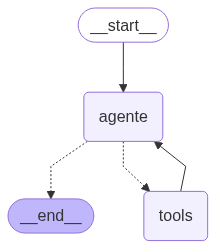

In [17]:
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Dotamos de funciones
llm_con_herramientas = llm.bind_tools(tools, parallel_tool_calls=False)

# Asistente
def agente(state: MessagesState):
   return {"messages": [llm_con_herramientas.invoke([sys_msg] + state["messages"])]}

# Grafo
builder = StateGraph(MessagesState)
builder.add_node("agente", agente)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "agente")
builder.add_conditional_edges(
    "agente",
    # Si es una llamada a herramienta -> ejecutamos
    # Si no, terminamos interacción con la respuesta de la LLM
    tools_condition,
)
builder.add_edge("tools", "agente")
agente = builder.compile()

# Show
display(Image(agente.get_graph(xray=True).draw_mermaid_png()))

In [18]:
messages = [HumanMessage(content="¿Cuanto es 4 * 5?")]
messages = agente.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

¿Cuanto es 4 * 5?
================================== Ai Message ==================================
Tool Calls:
  multiply (f7a3b473-642f-4634-98b0-01e35071ed9e)
 Call ID: f7a3b473-642f-4634-98b0-01e35071ed9e
  Args:
    a: 4.0
    b: 5.0
================================= Tool Message =================================
Name: multiply

20
================================== Ai Message ==================================

4 * 5 = 20


En este caos la LLM pide al asistente/agente que ejecute la acción y retorne el resultado para así poder responder la pregunta inicial. Estas herramientas pueden tomar cualquier forma de función o operación realizable por la máquina ejecutando la acción.